In [6]:
import cv2
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
import PIL
import random

from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

Retrieve all chips from folders... assign their class based on what subfolder they are in (adult_females, adult_males, etc.)

In [7]:
images_root = pathlib.Path('../results/bbox_chips')
print('Chip Folders: ', '\n', '-' * 50)
for item in images_root.iterdir():
    print(item)
all_image_paths = list(images_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.seed(42)
random.shuffle(all_image_paths)  # shuffle now for train test split later

print('-' * 50)
print(f'Total image count is {len(all_image_paths)}')

Chip Folders:  
 --------------------------------------------------
..\results\bbox_chips\adult_females
..\results\bbox_chips\adult_males
..\results\bbox_chips\juveniles
..\results\bbox_chips\pups
..\results\bbox_chips\subadult_males
--------------------------------------------------
Total image count is 1229


In [8]:
all_image_paths[0:10]

['..\\results\\bbox_chips\\pups\\43_pups_119.png',
 '..\\results\\bbox_chips\\juveniles\\48_juveniles_126.png',
 '..\\results\\bbox_chips\\adult_females\\45_adult_females_475.png',
 '..\\results\\bbox_chips\\adult_males\\45_adult_males_54.png',
 '..\\results\\bbox_chips\\adult_females\\43_adult_females_215.png',
 '..\\results\\bbox_chips\\pups\\43_pups_199.png',
 '..\\results\\bbox_chips\\juveniles\\48_juveniles_122.png',
 '..\\results\\bbox_chips\\adult_females\\41_adult_females_39.png',
 '..\\results\\bbox_chips\\adult_females\\47_adult_females_603.png',
 '..\\results\\bbox_chips\\adult_females\\48_adult_females_658.png']

In [9]:
label_names = sorted(item.name for item in images_root.glob('*/')
                     if item.is_dir())

In [10]:
label_names

['adult_females', 'adult_males', 'juveniles', 'pups', 'subadult_males']

In [11]:
label_to_index = dict((name, index) for index, name in enumerate(label_names))
label_to_index

{'adult_females': 0,
 'adult_males': 1,
 'juveniles': 2,
 'pups': 3,
 'subadult_males': 4}

In [12]:
all_image_labels = [
    label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths
]
all_image_labels[0:10]

[3, 2, 0, 1, 0, 3, 2, 0, 0, 0]

In [13]:
len(all_image_labels)

1229

In [14]:
len(all_image_paths)

1229

In [15]:
#all_image_arrays = [cv2.imread(str(i)).ravel() for i in all_image_paths]
# ValueError: setting an array element with a sequence.
all_image_arrays = [cv2.imread(str(i)) for i in all_image_paths]
all_image_arrays = [cv2.resize(img, (80, 80)) for img in all_image_arrays]
all_image_arrays = [
    cv2.cvtColor(i, cv2.COLOR_BGR2GRAY).ravel() for i in all_image_arrays
]  #.ravel()

In [16]:
X, y = all_image_arrays, all_image_labels

In [17]:
X = np.array(X)
# y = np.array(data['label'])

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.12,
                                                    random_state=42,
                                                    shuffle=True)

In [19]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [20]:
y[0:20]

[3, 2, 0, 1, 0, 3, 2, 0, 0, 0, 3, 1, 1, 0, 2, 0, 0, 3, 1, 0]

In [21]:
print("Label codes: ", label_to_index)
print("Prediction: ", sgd_clf.predict(X[0:20]))
print("Actual: ", y[0:20])

Label codes:  {'adult_females': 0, 'adult_males': 1, 'juveniles': 2, 'pups': 3, 'subadult_males': 4}
Prediction:  [3 4 4 1 4 3 3 4 0 4 3 1 1 4 4 4 0 3 4 0]
Actual:  [3, 2, 0, 1, 0, 3, 2, 0, 0, 0, 3, 1, 1, 0, 2, 0, 0, 3, 1, 0]


In [22]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)

conf_matrix = confusion_matrix(y_train, y_train_pred)
conf_matrix

array([[371,  59,  63,  63,  48],
       [ 42,  10,   7,   4,   4],
       [ 75,  11,  12,  23,   5],
       [ 20,   1,   7, 210,   2],
       [ 28,   2,   5,   8,   1]], dtype=int64)

In [23]:
sgd_clf.classes_

array([0, 1, 2, 3, 4])

In [24]:
# get scores of all instances in the training set with cross val predict
y_scores = cross_val_predict(sgd_clf,
                             X_train,
                             y_train,
                             cv=3,
                             method='decision_function')

#### Accuracy checks on SGD classifier

In [25]:
cross_val_score(sgd_clf, X_train, y_train, cv=5, scoring='accuracy')

array([0.70642202, 0.65898618, 0.58796296, 0.71759259, 0.67757009])

#### Try with scaling

In [26]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=5, scoring='accuracy')

array([0.67889908, 0.64516129, 0.625     , 0.64814815, 0.60747664])

It seems scaling made this worse...

##### Confusion Matrix - Actual Classes on Left, Predicted on Top

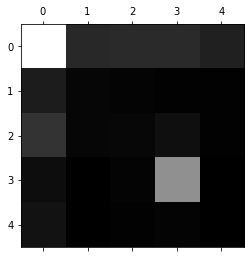

In [27]:
plt.matshow(conf_matrix, cmap=plt.cm.gray)
plt.show()

### Compare Random Forest Classifier vs SGD

In [28]:
forest_clf = RandomForestClassifier(random_state=42)

In [29]:
forest_clf.fit(X_train, y_train)
y_probas_forest = cross_val_predict(forest_clf,
                                    X_train,
                                    y_train,
                                    cv=3,
                                    method="predict_proba")

C:\Users\604572\Continuum\anaconda3\envs\MaskRCNN\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [30]:
print("Label codes: ", label_to_index)
print("Prediction: ", forest_clf.predict(X[0:20]))
print("Actual: ", y[0:20])

Label codes:  {'adult_females': 0, 'adult_males': 1, 'juveniles': 2, 'pups': 3, 'subadult_males': 4}
Prediction:  [3 2 0 1 0 3 2 0 0 0 3 1 1 0 0 0 0 3 1 0]
Actual:  [3, 2, 0, 1, 0, 3, 2, 0, 0, 0, 3, 1, 1, 0, 2, 0, 0, 3, 1, 0]


In [31]:
y[100]

0

In [32]:
forest_clf.predict_proba(
    [X[100]]
)  # shows probability per image of what it thinks the image show (80% change adult female here)

array([[0.8, 0. , 0.2, 0. , 0. ]])

In [33]:
cross_val_score(forest_clf, X_train, y_train, scoring='accuracy')

C:\Users\604572\Continuum\anaconda3\envs\MaskRCNN\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


array([0.72375691, 0.73055556, 0.70752089])

### KNN Classifier

In [34]:
# Create a k-NN classifier with 6 neighbors: knn
knn = KNeighborsClassifier(n_neighbors=6)

# Fit the classifier to the data
knn.fit(X_train, y_train)

# Print the accuracy
print(knn.score(X_test, y_test))
cross_val_score(knn, X_train, y_train, scoring='accuracy')

0.6621621621621622


C:\Users\604572\Continuum\anaconda3\envs\MaskRCNN\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


array([0.68508287, 0.48611111, 0.61002786])

^^^^^ KNN scores similar to the SGD

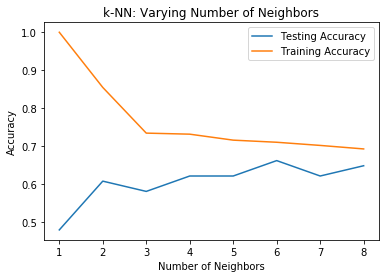

In [35]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)

    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

In [36]:
# Go back to 6 neighbors
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                     weights='uniform')

In [37]:
# Predict the labels of the test data: y_pred
y_pred = knn.predict(X_test)

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[51  1 16  4  0]
 [ 7  0  3  0  0]
 [ 7  0  9  8  0]
 [ 3  0  0 38  0]
 [ 1  0  0  0  0]]
              precision    recall  f1-score   support

           0       0.74      0.71      0.72        72
           1       0.00      0.00      0.00        10
           2       0.32      0.38      0.35        24
           3       0.76      0.93      0.84        41
           4       0.00      0.00      0.00         1

    accuracy                           0.66       148
   macro avg       0.36      0.40      0.38       148
weighted avg       0.62      0.66      0.64       148



C:\Users\604572\Continuum\anaconda3\envs\MaskRCNN\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Cross Val Scores

In [38]:
print('KNN scores: ', cross_val_score(knn, X, y, cv=5, scoring='accuracy'))
print('SGD scores: ', cross_val_score(sgd_clf, X, y, cv=5, scoring='accuracy'))
print('forest_clf scores: ',
      cross_val_score(forest_clf, X, y, cv=5, scoring='accuracy'))

KNN scores:  [0.5766129  0.60569106 0.59183673 0.65714286 0.5755102 ]
SGD scores:  [0.56048387 0.6504065  0.65714286 0.63673469 0.53877551]
forest_clf scores:  [0.67741935 0.72357724 0.70612245 0.71428571 0.73469388]


### Look at hyperparameters for forest_clf

In [39]:
from pprint import pprint
pprint(forest_clf.get_params())

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [40]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [41]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune

# Takes 30 minutes, dont need to run each time. Best params/estimator saved below.

# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator=forest_clf,
#                                param_distributions=random_grid,
#                                n_iter=50,
#                                cv=3,
#                                verbose=2,
#                                random_state=42,
#                                n_jobs=-1)
# # Fit the random search model
# rf_random.fit(X_train, y_train)

In [43]:
# rf_grid_search_best_params = rf_random.best_params_
# rf_grid_search_best_params

In [45]:
# rf_grid_search_best_estimator = rf_random.best_estimator_
# rf_grid_search_best_estimator

In [48]:
rf_clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [49]:
"""
best_estimator = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
"""
                       
best_params = {'n_estimators': 1200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}

In [51]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
cross_val_score(rf_clf, X, y)

^^^ Better results after gridsearch

In [ ]:
best_est_y_pred = rf_grid_search_best_estimator.predict(X_test)

In [ ]:
confusion_matrix(y_test, best_est_y_pred)